In [13]:
import pandas as pd
import os
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from skimage import io
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = "/content/drive/MyDrive/MNIST_Bounding_Box/MNIST_Converted_Testing.zip"
output_dir = "/content/MNIST"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

zip_path = "/content/drive/MyDrive/MNIST_Bounding_Box/MNIST_Converted_Training.zip"
output_dir = "/content/MNIST"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(output_dir)

In [4]:
df1 = pd.read_csv("/content/drive/MyDrive/MNIST_Bounding_Box/training_data.csv", header = None)
root_dir1 = "/content/MNIST/MNIST_Converted_Training"
df2 = pd.read_csv("/content/drive/MyDrive/MNIST_Bounding_Box/test_data.csv", header = None)
root_dir2 = "/content/MNIST/MNIST_Converted_Testing"
print(df1, df2)

                                 0  1   2   3
0          converted_training1.png  5  20   0
1          converted_training2.png  0  33  13
2          converted_training3.png  4  14   7
3          converted_training4.png  1  33  38
4          converted_training5.png  9  68   3
...                            ... ..  ..  ..
59995  converted_training59996.png  8  39   4
59996  converted_training59997.png  3  52  28
59997  converted_training59998.png  5   5  26
59998  converted_training59999.png  6  45  40
59999  converted_training60000.png  8  34  57

[60000 rows x 4 columns]                                0  1   2   3
0         converted_testing1.png  7  59  44
1         converted_testing2.png  2  48  11
2         converted_testing3.png  1  65  30
3         converted_testing4.png  0  10   3
4         converted_testing5.png  4  38  60
...                          ... ..  ..  ..
9995   converted_testing9996.png  2  11  38
9996   converted_testing9997.png  3  63  27
9997   converted_testing99

In [5]:
class MNIST_Dataset(Dataset):
    def __init__(self, dataframe, root_dir):
        self.annotations = dataframe
        self.root_dir = root_dir

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        image = torch.tensor(image).double().unsqueeze(0)

        y_label=torch.tensor(int(self.annotations.iloc[index, 1]))

        corners = torch.tensor(self.annotations.iloc[index, 2 : ].values.astype(float)).double() / 100

        return (image, y_label, corners)

In [6]:
batch_size = 100
train_dataset = MNIST_Dataset(df1, root_dir1)
test_dataset = MNIST_Dataset(df2, root_dir2)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,32, kernel_size = 4, stride = 2, padding = 1),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0))

        # self.fc1 = nn.Linear(760384, 16928)
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(2304, 500),
                                nn.Linear(500, 2),
                                 nn.Sigmoid())

    def forward(self,data):
        x = self.cnn(data)
        bb = self.fc(x)
        return bb

model1 = CNN1().double().to(device)
model1

CNN1(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=2, bias=True)
    (3): Sigmoid()
  )
)

In [9]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1,32, kernel_size = 4, stride = 2, padding = 1),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0))

        self.classifier = nn.Sequential(
                                  nn.Conv2d(256, 512, kernel_size = 3, stride = 1, padding = 1),
                                  nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
                                  nn.Flatten(),
                                  nn.ReLU(),
                                  nn.Linear(4608, 10),
                                 nn.Sigmoid())

    def forward(self,data):
        x = self.cnn(data)
        cls = self.classifier(x)
        return cls

model2 = CNN2().double().to(device)
model2

CNN2(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): ReLU()
    (4): Linear(in_features=4608, out_features=10, bias=True)
    (5): Sigm

In [12]:
total_step = len(train_loader)
acc_lst = []
loss_lst = []
classes=[0,1]
num_epochs = 4
loss_criteria_cls = nn.CrossEntropyLoss()
loss_criteria_bb = nn.MSELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.00006)
optimizer2 = torch.optim.Adam(model2.parameters(), lr = 0.00006)
for epoch in range(num_epochs):
    for i, (images, labels, corners) in enumerate(tqdm(train_loader)):
        images = images.to(device)
        labels = F.one_hot(labels, num_classes=10)
        labels = labels.type(torch.FloatTensor)
        labels = labels.to(device)

        corners = corners.to(device)

        bb = model1(images)
        cls = model2(images)

        loss_cls = loss_criteria_cls(cls, labels)
        loss_lst.append(loss_cls.item())

        optimizer2.zero_grad()
        loss_cls.backward()
        optimizer2.step()

        loss_bb = loss_criteria_bb(bb, corners)
        loss_lst.append(loss_bb.item())

        optimizer1.zero_grad()
        loss_bb.double().backward()
        optimizer1.step()

        labels =  torch.argmax(labels, dim=1)
        total = labels.size(0)
        _, predicted = torch.max(cls.data, 1)
        correct = (predicted == labels).sum().item()
        acc_lst.append((correct / total) * 100)
        if i%50 == 0:
            print('Epoch [{}/{}], Loss_Cls: {:.8f}, Loss_bb: {:.8f}, Accuracy:{:.2f}%'.format(epoch + 1, num_epochs, loss_cls.item(), loss_bb.item(), (correct / total) * 100))

    print(bb[0], corners[0])
    print('Epoch [{}/{}], Loss_Cls: {:.8f}, Loss_bb: {:.8f}, Accuracy:{:.2f}%'.format(epoch + 1, num_epochs, loss_lst[-2], loss_lst[-1], acc_lst[-1]))

  0%|          | 1/600 [00:01<15:58,  1.60s/it]

Epoch [1/2], Loss_Cls: 1.70073927, Loss_bb: 0.00030139, Accuracy:81.00%


  8%|▊         | 51/600 [01:12<12:44,  1.39s/it]

Epoch [1/2], Loss_Cls: 1.65751119, Loss_bb: 0.00037437, Accuracy:82.00%


 17%|█▋        | 101/600 [02:22<11:42,  1.41s/it]

Epoch [1/2], Loss_Cls: 1.60437821, Loss_bb: 0.00025738, Accuracy:85.00%


 25%|██▌       | 151/600 [03:32<10:31,  1.41s/it]

Epoch [1/2], Loss_Cls: 1.61880107, Loss_bb: 0.00027892, Accuracy:84.00%


 34%|███▎      | 201/600 [04:42<09:18,  1.40s/it]

Epoch [1/2], Loss_Cls: 1.58085335, Loss_bb: 0.00019482, Accuracy:90.00%


 42%|████▏     | 251/600 [05:52<08:11,  1.41s/it]

Epoch [1/2], Loss_Cls: 1.55967623, Loss_bb: 0.00021520, Accuracy:91.00%


 50%|█████     | 301/600 [07:02<07:01,  1.41s/it]

Epoch [1/2], Loss_Cls: 1.54782122, Loss_bb: 0.00019027, Accuracy:91.00%


 58%|█████▊    | 351/600 [08:12<05:52,  1.42s/it]

Epoch [1/2], Loss_Cls: 1.56341951, Loss_bb: 0.00018131, Accuracy:92.00%


 67%|██████▋   | 401/600 [09:22<04:39,  1.41s/it]

Epoch [1/2], Loss_Cls: 1.55729722, Loss_bb: 0.00016102, Accuracy:88.00%


 75%|███████▌  | 451/600 [10:32<03:30,  1.41s/it]

Epoch [1/2], Loss_Cls: 1.55097845, Loss_bb: 0.00015333, Accuracy:92.00%


 84%|████████▎ | 501/600 [11:42<02:23,  1.45s/it]

Epoch [1/2], Loss_Cls: 1.55417885, Loss_bb: 0.00015422, Accuracy:87.00%


 92%|█████████▏| 551/600 [12:52<01:09,  1.41s/it]

Epoch [1/2], Loss_Cls: 1.50958594, Loss_bb: 0.00019451, Accuracy:93.00%


100%|██████████| 600/600 [14:01<00:00,  1.40s/it]


tensor([0.4147, 0.5947], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>) tensor([0.4000, 0.6000], device='cuda:0', dtype=torch.float64)
Epoch [1/2], Loss_Cls: 1.52997388, Loss_bb: 0.00018601, Accuracy:95.00%


  0%|          | 1/600 [00:01<13:51,  1.39s/it]

Epoch [2/2], Loss_Cls: 1.50892939, Loss_bb: 0.00012339, Accuracy:97.00%


  8%|▊         | 51/600 [01:13<12:53,  1.41s/it]

Epoch [2/2], Loss_Cls: 1.49338004, Loss_bb: 0.00012166, Accuracy:97.00%


 17%|█▋        | 101/600 [02:23<11:44,  1.41s/it]

Epoch [2/2], Loss_Cls: 1.51396760, Loss_bb: 0.00010083, Accuracy:94.00%


 25%|██▌       | 151/600 [03:33<10:35,  1.42s/it]

Epoch [2/2], Loss_Cls: 1.52001406, Loss_bb: 0.00012686, Accuracy:96.00%


 34%|███▎      | 201/600 [04:43<09:20,  1.40s/it]

Epoch [2/2], Loss_Cls: 1.51006085, Loss_bb: 0.00009340, Accuracy:95.00%


 42%|████▏     | 251/600 [05:53<08:09,  1.40s/it]

Epoch [2/2], Loss_Cls: 1.49387888, Loss_bb: 0.00009217, Accuracy:99.00%


 50%|█████     | 301/600 [07:03<07:00,  1.41s/it]

Epoch [2/2], Loss_Cls: 1.52984195, Loss_bb: 0.00010273, Accuracy:94.00%


 58%|█████▊    | 351/600 [08:13<05:49,  1.41s/it]

Epoch [2/2], Loss_Cls: 1.49803758, Loss_bb: 0.00013691, Accuracy:99.00%


 67%|██████▋   | 401/600 [09:23<04:40,  1.41s/it]

Epoch [2/2], Loss_Cls: 1.50485928, Loss_bb: 0.00010694, Accuracy:96.00%


 75%|███████▌  | 451/600 [10:35<04:03,  1.64s/it]

Epoch [2/2], Loss_Cls: 1.50833296, Loss_bb: 0.00007465, Accuracy:96.00%


 84%|████████▎ | 501/600 [11:47<02:21,  1.43s/it]

Epoch [2/2], Loss_Cls: 1.50650116, Loss_bb: 0.00010049, Accuracy:96.00%


 92%|█████████▏| 551/600 [12:57<01:08,  1.41s/it]

Epoch [2/2], Loss_Cls: 1.50169504, Loss_bb: 0.00008725, Accuracy:96.00%


100%|██████████| 600/600 [14:06<00:00,  1.41s/it]

tensor([0.4712, 0.4973], device='cuda:0', dtype=torch.float64,
       grad_fn=<SelectBackward0>) tensor([0.4700, 0.5100], device='cuda:0', dtype=torch.float64)
Epoch [2/2], Loss_Cls: 1.50117458, Loss_bb: 0.00013284, Accuracy:97.00%


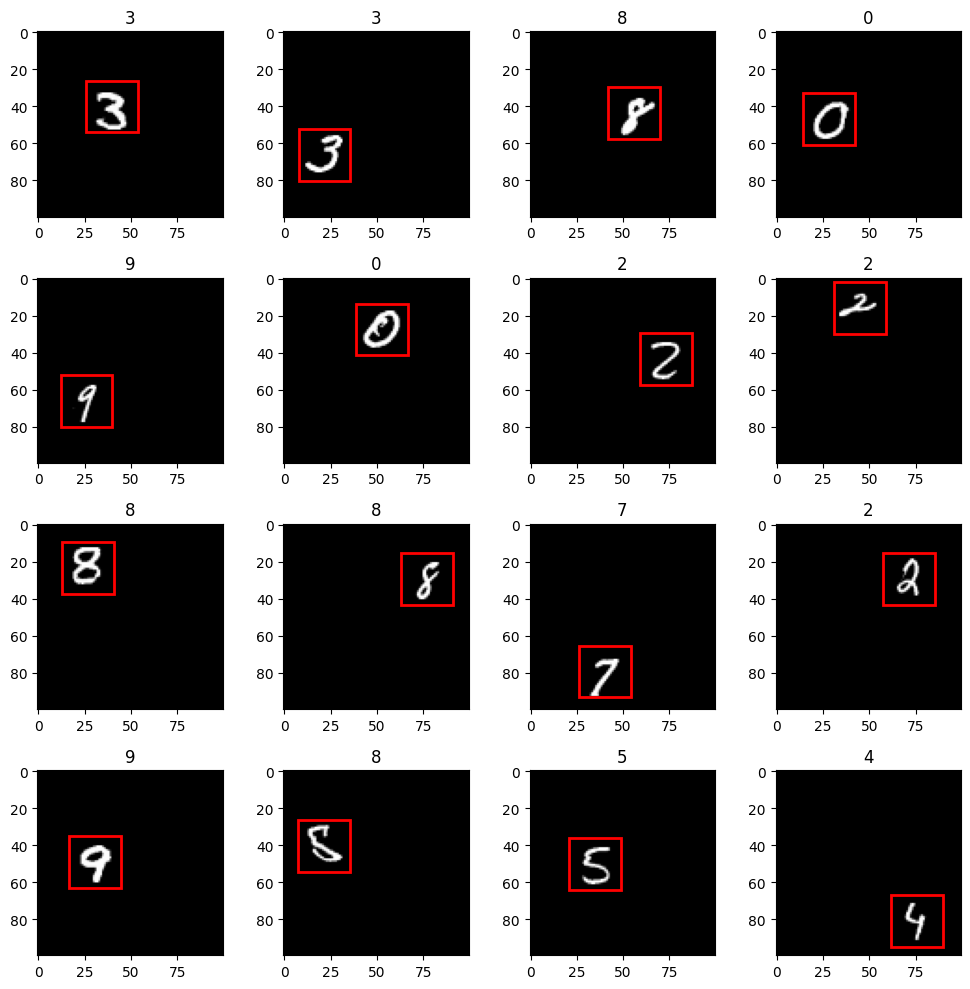

In [29]:
import matplotlib.pyplot as plt
import random

# Set the number of rows and columns for the grid
num_rows = 4
num_cols = 4

# Create a figure and axes for the grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i in range(num_rows):
    for j in range(num_cols):
        index = random.randint(0, 10000)
        image, cls, bb1 = train_dataset[index]
        bb = model1(image.unsqueeze(0).to(device))
        cls = model2(image.unsqueeze(0).to(device))

        # Plot the image
        axes[i, j].imshow(image.permute(1, 2, 0), cmap="gray")

        # Set the title as the predicted class
        num = torch.argmax(cls, dim = 1).item()
        axes[i, j].set_title(num)

        # Convert the bounding box predictions to numpy array and scale
        bb = bb.cpu().detach().numpy()
        bb1 = bb1 * 100
        bb = bb * 100

        # Get the x and y coordinates of the bounding box
        x, y = bb[0, 0], bb[0, 1]

        # Add a rectangle patch to the image
        rect = plt.Rectangle((x, y), 28, 28, linewidth=2, edgecolor='r', facecolor='none')
        axes[i, j].add_patch(rect)

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()
